In [32]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [33]:
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
sys.path.append("/Users/gregoirelejay/dev/personal/tag_walk/tag_walk") 

In [34]:
# import torchvision
# import matplotlib.pyplot as plt
# import numpy as np

# to_pl = transforms.ToPILImage()
# plt.imshow(to_pl(tw_dataset[0][0]))

# Inspecting the model

In [35]:
from fachung.models.tagwalk_classifier import TagWalkClassifier

tw_class = TagWalkClassifier('../data/tag_walk/',
                              batch_size=4, num_epochs=3,
                              debug=False, reset=False, output_dir='../data/training_logs/')
tw_class.read_model()

print(tw_class.history.keys())

Dataset sizes:
    Train:      (19516,)
    Validation: (4879,)
    Test:       (4879,)


2017-09-06 15:15:47 Chromecast.home root[71085] INFO Trying to load ../data/training_logs//TagWalkClassifier.pkl


dict_keys(['current_epoch', 'batch_size', 'num_epoch', 'loss', 'val_loss', 'loss_epoch', 'val_loss_epoch'])


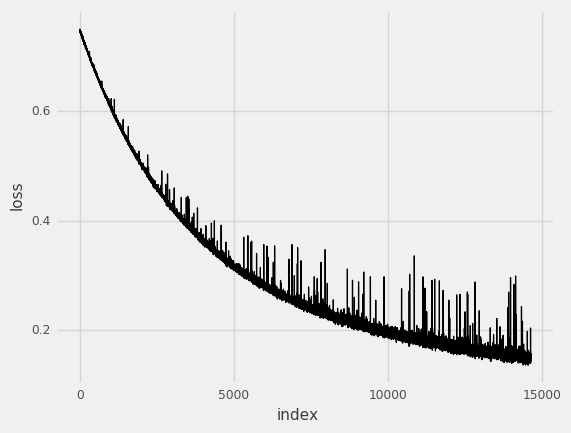

<ggplot: (277824313)>

In [43]:
import plotnine as gg
import pandas as pd


df = pd.DataFrame({'loss':tw_class.history['loss']})
df['index'] = df.index
gg.ggplot(df) + gg.geom_line(gg.aes(x='index', y='loss')) + gg.theme_538()

In [48]:
test_loader = tw_class.testing_loader
model = tw_class.model
classes = tw_class.classes

to_pl = transforms.ToPILImage()

import torch.nn.functional as F

model.eval()

def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(test_loader):
        inputs, labels, img_path = data
        inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        print(outputs)
        print(F.sigmoid(outputs))
        _, preds = torch.max(outputs.data, 1)
        
        output_mat = outputs.data.cpu().numpy()
        target_mat = labels.data.cpu().numpy()
        for batch_id in range(output_mat.shape[0]):
            print("-------")
            max_idx = np.argpartition(output_mat[batch_id], 10)[:10]
            print(max_idx)
            print("IMG: %s \n Predicted: %s \n Truth: %s" % (
                img_path[batch_id],
                classes[max_idx],
                classes[
                    np.where(target_mat[batch_id] == 1)
                ]))
            print("ALT:")
            max_idx = np.where(output_mat[batch_id] > 0.5)
            print(max_idx)
            print("IMG: %s \n Predicted: %s \n Truth: %s" % (
                img_path[batch_id],
                classes[max_idx],
                classes[
                    np.where(target_mat[batch_id] == 1)
                ]))
        break

#         for j in range(inputs.size()[0]):
#             images_so_far += 1
#             ax = plt.subplot(num_images//2, 2, images_so_far)
# #             plt.figure(figsize=(10, 10))
#             ax.axis('off')
#             ax.set_title('predicted: {}'.format(classes[preds[j]]))
#             imshow(to_pl(inputs.cpu().data[j]))

#             if images_so_far == num_images:
#                 return

In [49]:
visualize_model(model)

Variable containing:
-1.9656 -1.9794 -2.7605  ...  -1.7194 -1.6196 -1.8814
-2.0861 -2.1809 -2.1977  ...  -1.6484 -1.6982 -1.6613
-1.5692 -2.3015 -1.7731  ...  -1.7442 -1.8741 -1.5653
-2.7505 -3.3268 -1.8322  ...  -1.7159 -1.9082 -1.7397
[torch.FloatTensor of size 4x655]

Variable containing:
 0.1229  0.1214  0.0595  ...   0.1519  0.1653  0.1322
 0.1105  0.1015  0.1000  ...   0.1613  0.1547  0.1596
 0.1723  0.0910  0.1452  ...   0.1488  0.1331  0.1729
 0.0601  0.0347  0.1380  ...   0.1524  0.1292  0.1494
[torch.FloatTensor of size 4x655]

-------
[201 276 396  30 163 149  82 477 188 445]
IMG: ../data/tag_walk/images/all/23_FENDI_DONNA_FW_16-17_.JPG 
 Predicted: ['equestrian' 'gypsy' 'nun' 'ballerina' 'cross' 'corduroy' 'bohemian'
 'pumps' 'drape' 'pink-jumper'] 
 Truth: ['blue' 'blue-jacket' 'bomber' 'fur' 'midi' 'navy-blue' 'pleats' 'skirt'
 'strict']
ALT:
(array([], dtype=int64),)
IMG: ../data/tag_walk/images/all/23_FENDI_DONNA_FW_16-17_.JPG 
 Predicted: [] 
 Truth: ['blue' 'blue-jack

In [63]:
from graphviz import Digraph
import re
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models


def make_dot(var, params):
    param_map = {id(v): k for k, v in params.items()}
    
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()
    
    def size_to_str(size):
        return '('+(', ').join(['%d'% v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                node_name = '%s\n %s' % (param_map.get(id(u)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot

In [75]:
print(model)

ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

In [90]:
feature_extractor = nn.Sequential(*list(model.children())[:-2])
class_weighter = nn.Sequential(*list(model.children())[:-1])

In [95]:
import numpy as np
for i, data in enumerate(test_loader):
    inputs, labels, img_path = data
    inputs, labels = Variable(inputs), Variable(labels)

    outputs = feature_extractor(inputs)
    class_weights = class_weighter(inputs)
    conv_outputs = outputs[0].data.cpu().numpy()
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[1:3])
#     print(cam)
#     print(class_weights)
    target_class = 1
    for i, w in enumerate(class_weights[:, target_class]):
        cam +=  conv_outputs[i, :, :]
    print(cam)
    break

[[ 3.87931633  5.43117428  6.84020615  6.50841045  5.09973955  4.35748005
   3.21372366]
 [ 5.29686403  7.32127953  6.90454388  7.26271152  3.27393198  5.13797903
   5.78631496]
 [ 5.2273345   8.31282234  9.40685463  7.79715776  4.04397964  4.48907471
   4.51025343]
 [ 5.0350976   7.98308754  8.39721012  6.66860056  2.60615182  3.08070183
   2.16655469]
 [ 6.47694683  9.47051239  4.96564531  4.74222994  1.97507548  0.4090479
   0.23092116]
 [ 8.03375721  8.06864262  3.47712088  3.40786695  1.78303087  1.82380354
   2.00484848]
 [ 5.27673721  5.5357976   3.49029684  2.52119875  0.68547672  0.
   0.70518965]]
